# CTR Prediction on Ad data provided by Avazu

## Importing neccesary libraries

In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dask # used for in-memory large compution on a single machine
import random

#for visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot, download_plotlyjs

import sklearn
import matplotlib.dates as mdates

In [3]:
matplotlib.style.use('ggplot')

## Data Sampling

As the data in quite large(~6gb) and the best way to handle this amount of data is to use cloud technologies like AWS. However, I am trying to handle this using single machine and unavailability of resources. The best approach to handle amount of data is **"Random Sampling"**

In [4]:

n = 40428967 # total number of rows in the data

sample_size = 1000000
random.seed(101) ## for maintaining the seed state.
skip_values = sorted(random.sample(range(1,n), n-sample_size))

In [6]:
#To manipulate the date feature so it can further analyzed at the EDA stage
parse_date = lambda date: pd.datetime.strptime(date, '%y%m%d%H')

## Loading the Data

In [8]:
from requirements import *
# train_path = "/Users/akash-mac/Desktop/My Docs/Self-Projects/Datasets/CTR Data/train"
train_data = pd.read_csv(train_path, 
                         parse_dates= ['hour'], 
                         date_parser=parse_date, 
                         skiprows=skip_values)

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 24 columns):
id                  1000000 non-null uint64
click               1000000 non-null int64
hour                1000000 non-null datetime64[ns]
C1                  1000000 non-null int64
banner_pos          1000000 non-null int64
site_id             1000000 non-null object
site_domain         1000000 non-null object
site_category       1000000 non-null object
app_id              1000000 non-null object
app_domain          1000000 non-null object
app_category        1000000 non-null object
device_id           1000000 non-null object
device_ip           1000000 non-null object
device_model        1000000 non-null object
device_type         1000000 non-null int64
device_conn_type    1000000 non-null int64
C14                 1000000 non-null int64
C15                 1000000 non-null int64
C16                 1000000 non-null int64
C17                 1000000 non-null int64
C18      

## Memory management and Optimization

As we can see in the above cell, the memory usage is 183.1+ MB. Altering the data types from **int64** to **int32** will reduce the memory usage using **NumPy** 

In [10]:
data_types = {
    'id': np.str,
    'click': np.bool_,
    'hour': np.str,
    'C1': np.uint16,
    'banner_pos': np.uint16,
    'site_id': np.object,
    'site_domain': np.object,
    'site_category': np.object,
    'app_id': np.object,
    'app_domain': np.object,
    'app_category': np.object,
    'device_id': np.object,
    'device_ip': np.object,
    'device_model': np.object,
    'device_type': np.uint16,
    'device_conn_type': np.uint16,
    'C14': np.uint16,
    'C15': np.uint16,
    'C16': np.uint16,
    'C17': np.uint16,
    'C18': np.uint16,
    'C19': np.uint16,
    'C20': np.uint16,
    'C21': np.uint16
}

In [11]:
#Reloading the data with new data types
train_data = pd.read_csv(train_path, 
                         parse_dates= ['hour'], 
                         date_parser=parse_date, 
                         skiprows=skip_values, 
                         dtype = data_types)

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 24 columns):
id                  1000000 non-null object
click               1000000 non-null bool
hour                1000000 non-null datetime64[ns]
C1                  1000000 non-null uint16
banner_pos          1000000 non-null uint16
site_id             1000000 non-null object
site_domain         1000000 non-null object
site_category       1000000 non-null object
app_id              1000000 non-null object
app_domain          1000000 non-null object
app_category        1000000 non-null object
device_id           1000000 non-null object
device_ip           1000000 non-null object
device_model        1000000 non-null object
device_type         1000000 non-null uint16
device_conn_type    1000000 non-null uint16
C14                 1000000 non-null uint16
C15                 1000000 non-null uint16
C16                 1000000 non-null uint16
C17                 1000000 non-null uint16
C1

Memory usage decreased by 40% (107.8+ MB)

## Exploratory Data Analysis

In [14]:
train_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10005249248600843539,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,34547,79
1,10007768440836622373,False,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,e2a1ca37,2347f47a,...,1,0,15708,320,50,1722,0,35,65535,79
2,10018563981679953217,False,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,8bfb92e0,7801e8d9,...,1,0,17661,320,50,1996,1,41,34521,71
3,10019805607671159208,False,2014-10-21,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,0,0,21300,320,50,2446,3,171,34692,156
4,10020605367282200605,False,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,20359,216,36,2333,0,39,65535,157


In [15]:
train_data.describe()

,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1004.967288,0.287654,1.015138,0.331862,18846.665442,318.885044,60.099810,2113.138773,1.433999,227.073758,49074.132254,83.371591
std,1.097501,0.506580,0.528376,0.855389,4953.132982,21.502397,47.209081,608.925941,1.326595,350.678109,15448.163156,70.270973
min,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,34464.000000,1.000000
25%,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,34548.000000,23.000000
50%,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,34657.000000,61.000000
75%,1005.000000,1.000000,1.000000,0.000000,21894.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,65535.000000,101.000000
max,1012.000000,7.000000,5.000000,5.000000,24052.000000,1024.000000,1024.000000,2758.000000,3.000000,1839.000000,65535.000000,255.000000


### CTR - Click vs. No Click distribution

(%) of Clicked vs. Not Clicked

False    83.0383
True     16.9617
Name: click, dtype: float64


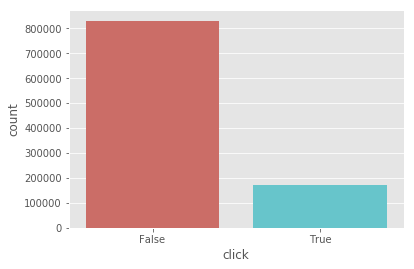

In [23]:
sns.countplot(x='click', data=train_data, palette='hls')
print("(%) of Clicked vs. Not Clicked\n")
print(train_data['click'].value_counts()*100/sample_size)

Click Through Rate for this sampled data is approx 17%, while the 83% did not clicked.

Let us check for the number of hours of total days of the data we have i.e. **10 day** i.e. **240 hours**

Text(0.5,1,'Number of clicks by hour')

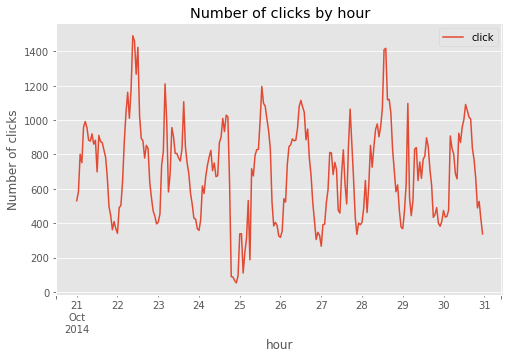

In [29]:
train_data.groupby('hour').agg({'click':'sum'}).plot(figsize = (8,5))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour')

The pattern looks pretty similar for all the 10 days. However, there are peaks between 22nd-23rd day and 28th-29th day. The lowest peak has be between 24th and 25th day.

### Breaking down date time feature and extracting hours

#### Hours

Text(0.5,1,'click trends by hour of day')

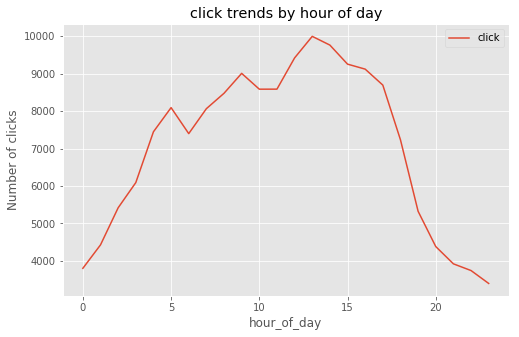

In [30]:
train_data['hour_of_day']=train_data.hour.apply(lambda x: x.hour)
train_data.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=(8,5))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day')

Observing the above plot, it can be seen that the highest number of ads have been clicked in the afternoon time i.e. between the 13th and 14th hour (1pm-2pm). The least were at the 0th hour (mid night). Just to compare clicks vs. not clicks we can see the impressions in the below plot

Text(0.5,1,'Hourly impressions vs. clicks')

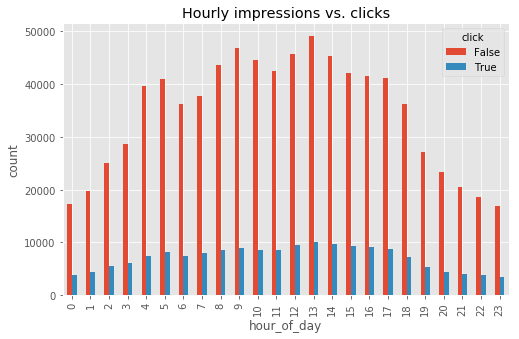

In [41]:
train_data.groupby(['hour_of_day', 'click']).size().unstack().plot(kind = 'bar', figsize = (8,5))
plt.ylabel('count')
plt.title('Hourly impressions vs. clicks')

### Calculating CTR using Impressions and Clicks

#### CTR - Hourly

In [63]:
df_click = train_data[train_data['click']==1]

In [64]:
df_hour = train_data[['hour_of_day', 'click']].groupby(['hour_of_day']).count().reset_index()

In [65]:
df_hour = df_hour.rename(columns={'click':'impressions'})

In [66]:
df_hour['click'] = df_click[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()['click']

In [67]:
df_hour['CTR'] = df_hour['click']*100/df_hour['impressions']

Plotting the Hourly CTR

In [73]:
df_hour.head()

,hour_of_day,impressions,click,CTR
0,0,21033,3805,18.090620
1,1,24113,4430,18.371833
2,2,30422,5419,17.812767
3,3,34761,6091,17.522511
4,4,47116,7446,15.803549


Text(0.5,1,'CTR - Hourly')

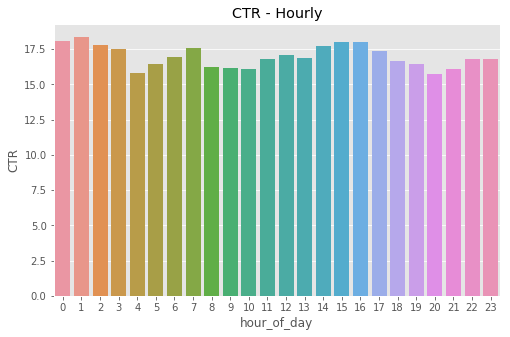

In [69]:
plt.figure(figsize=(8,5))
sns.barplot(x='hour_of_day',y='CTR', data=df_hour, palette=)
plt.title('CTR - Hourly')

Here we can observe that the CTR for the mid night hours is higher compared to their clicks and impressions.

#### Day of Week

In [78]:
train_data['day_of_week'] = train_data['hour'].apply(lambda val: val.weekday_name)

In [81]:
train_data[['day_of_week', 'click']].groupby(['day_of_week']).count()

,click
day_of_week,
Friday,82589
Monday,80000
Saturday,82935
Sunday,94948
Thursday,200192
Tuesday,231685
Wednesday,227651
